<div style="background-color:white; text-align:center; font-family:Arial, Helvetica, sans-serif; padding:45px;">
  <div style="color:#993520; font-size:54px; font-weight:bold; margin-bottom:10px;">
    SENTIMENT ANALYSIS OF U.S. SENATORS' TWEETS
  </div>
  <div style="color:#333; font-size:22px; margin-top:10px;">
    Dictionary-based sentiment analysis (VADER) + political communication insights (May–Oct 2020) 
    </div>
    Performed by: Zahra Eshtiaghi 476679 Under Supervision of Dr. Maciej Świtała
  </div>
</div>


### 1. Intro (what this notebook does)

**Topic.** U.S. senators use Twitter/X to communicate policy positions, react to events, and mobilize supporters. Because tweets are short, time-stamped, and public, they are a useful dataset for studying **political communication** and how sentiment relates to **public engagement**.

**Why dictionary-based sentiment?** This notebook applies two dictionary / corpus-based methods as transparent, fast baselines:

1. **Custom corpus lexicon (seed + PMI expansion)**: a **dataset-specific dictionary method** inspired by course material. I start with a small set of positive/negative **seed words**, then expand the lexicon using **co-occurrence statistics (PMI)** from the senators’ tweet corpus. Each tweet receives a sentiment score by summing lexicon weights (and I also compute a **normalized score** to reduce the effect of tweet length). This method is still dictionary-based, but it adapts the vocabulary to political Twitter language (hashtags, recurring phrases).

2. **VADER**: a **pre-built lexicon + rule-based** sentiment tool designed for social media. It requires **no training labels**, keeps punctuation/emojis useful, and outputs interpretable scores (`neg/neu/pos/compound`).

**Project objective (clear & measurable).**
Using ~30k senators’ tweets from **May 1–Oct 31, 2020**, the goal is to:

1. assign each tweet a **Negative / Neutral / Positive** label using **VADER** and the **custom corpus lexicon**,
2. describe sentiment patterns **by party/state and over time**,
3. examine whether sentiment is associated with **engagement** (likes/retweets/replies),
4. compare the two dictionary approaches and summarize main takeaways and limitations,
5. later compare dictionary outputs with supervised and transformer models in the full project.

**What you will see in this notebook.**

* Data audit + *light* preprocessing

  * For **VADER**, I keep punctuation/emojis because they carry sentiment signals.
  * For the **custom lexicon**, I tokenize and score based on words/hashtags in the learned dictionary.
* VADER scores (`neg/neu/pos/compound`) and 3-class labels (standard thresholds)
* Custom lexicon sentiment scores (raw + normalized) and 3-class labels (threshold-based)
* Exploratory analysis: overall distribution, monthly trends, party comparisons, engagement patterns
* Short conclusion + limitations (e.g., sarcasm, policy jargon, topic-vs-sentiment confusion, hashtag bias)

> Note: Both methods are **baselines**. Disagreement with supervised models is expected and is part of the project comparison.


### Part A — Dictionary-based sentiment analysis 

In [8]:
# !pip -q install vaderSentiment

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import Counter, defaultdict

plt.rcParams['figure.dpi'] = 120



### 1- Sentiment dictionary using seed words + PMI

In [23]:
# Load data
df = pd.read_csv("/Users/majid/Documents/3-third semester/text mining /project/senator sentiment/SENTIMENT-ANALYSIS-OF-U.S.-SENATORS-TWEETS/SENTIMENT-ANALYSIS-OF-U.S.-SENATORS-TWEETS/senator with sentiment csv/senator_twitter_May-Oct.csv")
text_col = "text_clean" if "text_clean" in df.columns else "text"
texts = df[text_col].fillna("").astype(str).tolist()

### Tokenizer

In [24]:

token_re = re.compile(r"[a-zA-Z']+")
def tokenize(s):
    return token_re.findall(s.lower())

docs = [list(set(tokenize(t))) for t in texts]  # set() per doc -> co-occurrence without repeats
N = len(docs)

### Seed sentiment dictionary 

In [25]:
seed = {
    # --- Positive (support/thanks/hope/safety) ---
    "thank": 1, "thanks": 1, "grateful": 1, "appreciate": 1,
    "proud": 1, "honor": 1, "heroes": 1, "veterans": 1,
    "support": 1, "supported": 1, "supporting": 1,
    "protect": 1, "protecting": 1, "protected": 1,
    "safe": 1, "safely": 1, "safety": 1,
    "relief": 1, "recovery": 1,
    "progress": 1, "improve": 1,
    "success": 1, "successful": 1,
    "hope": 1, "hopeful": 1,
    "bless": 1, "blessing": 1, "prayers": 1,
    "welcome": 1, "congratulations": 1, "excited": 1, "glad": 1,
    "historic": 1, "incredible": 1, "amazing": 1, "stronger": 1,

    # --- Negative (harm/crisis/violence/danger/failure) ---
    "crisis": -1, "disaster": -1,
    "deadly": -1, "death": -1, "deaths": -1,
    "killed": -1, "tragic": -1, "horrific": -1,
    "violence": -1, "violent": -1,
    "threat": -1, "threats": -1,
    "dangerous": -1, "danger": -1,
    "unemployment": -1,
    "illegal": -1, "unlawful": -1, "unconstitutional": -1,
    "fraud": -1,
    "hate": -1, "racist": -1,
    "attack": -1,
    "fail": -1, "failure": -1,
    "broken": -1, "sad": -1,
}

seed_words = set(seed.keys())

### Document frequency counts

In [26]:
df_count = Counter()
for d in docs:
    df_count.update(d)

# reduce noise (speed + quality)
min_df = 30
vocab = {w for w, c in df_count.items() if c >= min_df}

### Co-occurrence counts between (seed, other) in same document

In [27]:
co = Counter()
seed_df = Counter()
other_df = Counter()

for d in docs:
    d = [w for w in d if w in vocab]
    seeds_in = [w for w in d if w in seed_words]
    others_in = [w for w in d if w not in seed_words]
    if not seeds_in or not others_in:
        continue
    for s in seeds_in:
        seed_df[s] += 1
        for o in others_in:
            co[(s, o)] += 1
            other_df[o] += 1

### PMI and lexicon expansion

In [28]:
# PMI(s,o) = log2( p(s,o) / (p(s)p(o)) )
# Use counts over documents
total_docs = N

expanded = {}
for o, o_count in other_df.items():
    score = 0.0
    for s in seed_words:
        c_so = co.get((s, o), 0)
        if c_so == 0:
            continue
        p_so = c_so / N
        p_s = seed_df[s] / N
        p_o = o_count / N
        pmi = np.log2(p_so / (p_s * p_o))
        score += pmi * seed[s]
    if score != 0:
        expanded[o] = score





In [ ]:
# # Keep top-K strongest new words
# K = 500
# expanded_top = dict(sorted(expanded.items(), key=lambda x: abs(x[1]), reverse=True)[:K])

# sent_lexicon = {**seed, **expanded_top}

# print("Seed size:", len(seed), "| Expanded size:", len(expanded_top), "| Total lexicon:", len(sent_lexicon))


Seed size: 62 | Expanded size: 500 | Total lexicon: 562


In [30]:
K = 500
expanded_top = dict(sorted(expanded.items(), key=lambda x: abs(x[1]), reverse=True)[:K])


In [31]:
sent_lex = {**seed, **expanded_top}

print("Seed:", len(seed), "| Expanded:", len(expanded_top), "| Total:", len(sent_lex))

Seed: 62 | Expanded: 500 | Total: 562


### Score tweets using dictionary

In [29]:

def score_text(tokens, lex):
    return sum(lex.get(w, 0.0) for w in tokens)

scores = []
for t in texts:
    toks = tokenize(t)
    scores.append(score_text(toks, sent_lex))

df["custom_lex_score"] = scores


 ### Convert score -> label (tune thresholds if needed)

In [32]:

neg_th, pos_th = -0.5, 0.5
df["custom_lex_label"] = np.where(df["custom_lex_score"] <= neg_th, "Negative",
                           np.where(df["custom_lex_score"] >= pos_th, "Positive", "Neutral"))

df[["custom_lex_score", "custom_lex_label"]].head()

,custom_lex_score,custom_lex_label
0,96.105112,Positive
1,121.025207,Positive
2,0.000000,Neutral
3,56.676547,Positive
4,0.000000,Neutral


>These results show that some tweets receive **high positive scores** because the PMI-expanded lexicon contains many words with positive weights, and the model adds them together across the tweet. A score of **0** usually means that none of the tweet words matched the lexicon (so there was no sentiment evidence), or less commonly, positive and negative words cancelled each other out.

>One limitation of this approach is that the raw score is **dependent on tweet length**: longer tweets tend to get larger absolute scores simply because they contain more words that can contribute to the sum. For this reason, a better version is to also compute a **normalized sentiment score** (for example, score divided by number of tokens), so that tweets of different lengths can be compared more fairly.


### distribution + examples + normalization

In [33]:


# Basic distribution
df["custom_lex_score"].describe()

# How many of each label
df["custom_lex_label"].value_counts()

# Check how many tweets have score exactly 0
(df["custom_lex_score"] == 0).mean()

#  Normalize by length
df["n_tokens"] = df[text_col].fillna("").astype(str).apply(lambda s: len(tokenize(s)))
df["custom_lex_score_norm"] = df["custom_lex_score"] / df["n_tokens"].replace(0, np.nan)
df["custom_lex_score_norm"] = df["custom_lex_score_norm"].fillna(0)

df["custom_lex_score_norm"].describe()


count    30490.000000
mean         2.532230
std          2.301918
min        -13.200249
25%          1.076438
50%          2.286561
75%          3.684962
max         40.890009
Name: custom_lex_score_norm, dtype: float64

### Look at the “most positive / most negative / most neutral” tweets

In [34]:
cols_show = [text_col, "custom_lex_score", "custom_lex_score_norm", "custom_lex_label"]

print("Top Positive:")
display(df.sort_values("custom_lex_score_norm", ascending=False)[cols_show].head(10))

print("Top Negative:")
display(df.sort_values("custom_lex_score_norm", ascending=True)[cols_show].head(10))

print("Near Neutral (closest to 0):")
display(df.loc[df["custom_lex_score_norm"].abs().sort_values().index][cols_show].head(10))


Top Positive:


,text,custom_lex_score,custom_lex_score_norm,custom_lex_label
4454,#603Pride,40.890009,40.890009,Positive
12939,#Census2020,28.102929,28.102929,Positive
3750,"Happy Birthday, Coach! \n@phillipfulmer",104.614509,26.153627,Positive
13461,#InThisTogetherOhio,25.548936,25.548936,Positive
13570,#InThisTogetherOhio,25.548936,25.548936,Positive
13325,#InThisTogetherOhio,25.548936,25.548936,Positive
12960,#InThisTogetherOhio,25.548936,25.548936,Positive
13530,#InThisTogetherOhio,25.548936,25.548936,Positive
13607,#InThisTogetherOhio,25.548936,25.548936,Positive
12413,#InThisTogetherOhio,25.548936,25.548936,Positive


Top Negative:


,text,custom_lex_score,custom_lex_score_norm,custom_lex_label
13097,Total tests,-26.400497,-13.200249,Negative
13471,Total tests,-26.400497,-13.200249,Negative
13440,Today's #COVID19 dashboard:,-30.173705,-10.057902,Negative
13731,Today's tie: \n@XavierU\n,-30.173705,-10.057902,Negative
13526,Today's tie: \n@miamiuniversity\n,-30.173705,-10.057902,Negative
13394,Today's #COVID19 dashboard,-30.173705,-10.057902,Negative
12393,Today's #COVID19 data.,-30.173705,-10.057902,Negative
12333,Today's daily summary.,-30.173705,-10.057902,Negative
13579,Total Tests Performed,-26.400497,-8.800166,Negative
8724,"JULY 20, 2020\nNew cases: 12\nTotal cumulative...",-136.911809,-8.053636,Negative


Near Neutral (closest to 0):


,text,custom_lex_score,custom_lex_score_norm,custom_lex_label
9694,I have signed Executive Order 20-30 to extend ...,0.0,0.0,Neutral
10251,WATCH: Governor Inslee Media Availability,0.0,0.0,Neutral
2043,VOTE.,0.0,0.0,Neutral
18637,UPDATE: Daily COVID-19 data in Connecticut\n\n...,0.0,0.0,Neutral
24800,NaN,0.0,0.0,Neutral
24799,NaN,0.0,0.0,Neutral
2047,“If they won’t vote Republican then deny them ...,0.0,0.0,Neutral
24798,NaN,0.0,0.0,Neutral
23626,My heart breaks for the family of Sergeant Cra...,0.0,0.0,Neutral
10252,WATCH: I'm holding a media availability at 2:3...,0.0,0.0,Neutral


These examples show a typical limitation of dictionary/corpus methods:

1. **Hashtags can get extreme scores** even when they are not clearly emotional.
2. **Informational COVID/testing tweets can be wrongly labeled Negative** because the words are associated with negative events in the corpus.
3. **Many tweets become Neutral** simply because the lexicon does not cover their vocabulary (especially short/announcement tweets).

This is why lexicon-based sentiment is a useful baseline, but supervised/transformer models usually perform better: they can learn context, while the lexicon method relies mainly on word associations.


### Make labels using normalized score

In [35]:
neg_th, pos_th = -0.2, 0.2   # you can tune these
df["custom_lex_label_norm"] = np.where(df["custom_lex_score_norm"] <= neg_th, "Negative",
                               np.where(df["custom_lex_score_norm"] >= pos_th, "Positive", "Neutral"))

df["custom_lex_label_norm"].value_counts()


custom_lex_label_norm
Positive    25777
Neutral      3747
Negative      966
Name: count, dtype: int64

>The custom lexicon method predicts a highly skewed label distribution, with about 84.5% of tweets classified as Positive, 12.3% as Neutral, and only 3.2% as Negative. This indicates that the lexicon-based approach is biased toward positive sentiment, likely because many common political expressions and hashtags (e.g., “thank”, “support”, “proud”, and campaign/community hashtags) receive positive weights in the expanded lexicon. As a result, the method may overestimate positivity compared to supervised or transformer models.

## 2- VADER analysis:

### 4. Load and audit the dataset

In [3]:
DATA_PATH = "/Users/majid/Documents/3-third semester/text mining /project/senator sentiment/senator_twitter_May-Oct.csv"

df = pd.read_csv(DATA_PATH)
# drop index-like columns
df = df.drop(columns=[c for c in df.columns if c.lower().startswith('unnamed')], errors='ignore')

# parse time
# (tweet timestamps are treated as UTC here; adjust if you have timezone info)
df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)

print('Shape:', df.shape)
display(df.head(3))
print('Columns:', df.columns.tolist())

# missingness audit
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(10))

Shape: (30490, 15)


,tweet_id,time,text,replies,retweets,likes,from_user,from_content,twitter_id,name,state,party,gender,birth,age
0,1322145371108331520,2020-10-30 11:56:35+00:00,More jobs. More investment. More economic oppo...,40,24,143,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
1,1321926867696390144,2020-10-29 21:28:20+00:00,Marty and I are excited to be back on the camp...,46,26,107,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57
2,1321906471244845061,2020-10-29 20:07:17+00:00,ICYMI: Gov. Kemp announces 46 people snared in...,24,30,174,NaN,NaN,BrianKempGA,Brian Kemp,GA,Republican,Male,NaN,57


Columns: ['tweet_id', 'time', 'text', 'replies', 'retweets', 'likes', 'from_user', 'from_content', 'twitter_id', 'name', 'state', 'party', 'gender', 'birth', 'age']


birth           1.000000
from_content    0.912693
from_user       0.912332
text            0.004264
tweet_id        0.000000
time            0.000000
replies         0.000000
retweets        0.000000
likes           0.000000
twitter_id      0.000000
dtype: float64

### Light preprocessing for lexicon method 
VADER is designed for social media, but it can still be improved by basic cleaning:
- replace URLs with token
- replace @mentions with token
- keep emojis/punctuation (VADER uses them)
- remove excessive whitespace

In [6]:
def clean_for_vader(text: str) -> str:
    text = str(text)

    # Replace URLs and mentions with generic tokens
    text = re.sub(r"http\S+|www\.\S+", " URL ", text)
    text = re.sub(r"@\w+", " USER ", text)

    # Optional: convert newlines/tabs to space
    text = re.sub(r"\s+", " ", text).strip()

    return text

df["text_vader"] = df["text"].astype(str).apply(clean_for_vader)


### Compute VADER sentiment scores
VADER returns 4 scores: neg, neu, pos, compound.
- compound is the main one (range: -1 to +1)

In [7]:
analyzer = SentimentIntensityAnalyzer()

def vader_scores(text: str):
    s = analyzer.polarity_scores(text)
    return s["neg"], s["neu"], s["pos"], s["compound"]

scores = df["text_vader"].apply(vader_scores)
df[["vader_neg", "vader_neu", "vader_pos", "vader_compound"]] = pd.DataFrame(scores.tolist(), index=df.index)

df[["vader_neg", "vader_neu", "vader_pos", "vader_compound"]].describe()


,vader_neg,vader_neu,vader_pos,vader_compound
count,30490.000000,30490.000000,30490.000000,30490.000000
mean,0.039116,0.829913,0.130966,0.327179
std,0.065634,0.125805,0.115531,0.466304
min,0.000000,0.000000,0.000000,-0.984700
25%,0.000000,0.748000,0.024000,0.000000
50%,0.000000,0.835000,0.117000,0.401900
75%,0.063000,0.925000,0.201000,0.743000
max,1.000000,1.000000,1.000000,0.988700


### Convert VADER compound into 3-class labels (standard thresholds)
Standard VADER thresholds:
- compound >= 0.05 → Positive
- compound <= -0.05 → Negative
- else → Neutral

In [8]:
def vader_label(compound: float) -> str:
    if compound >= 0.05:
        return "Positive"
    elif compound <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["vader_label"] = df["vader_compound"].apply(vader_label)

print(df["vader_label"].value_counts())


vader_label
Positive    19632
Neutral      6082
Negative     4776
Name: count, dtype: int64


### Overall VADER distribution (plot)

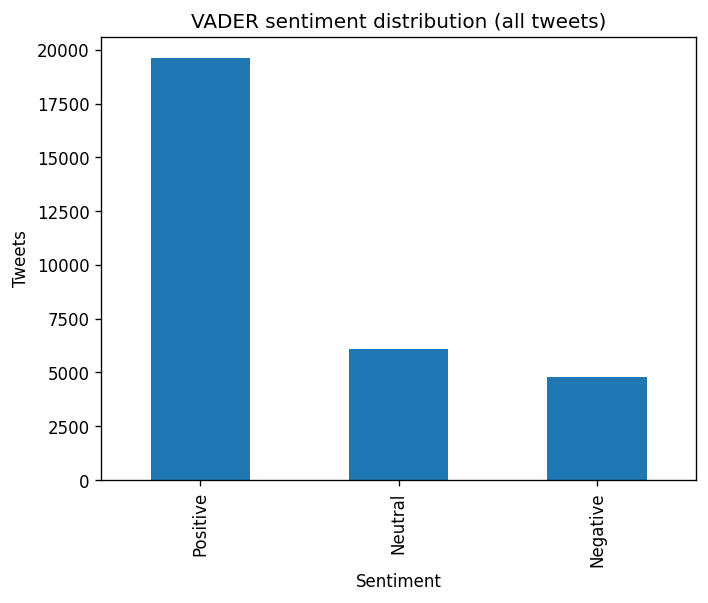

In [9]:
df["vader_label"].value_counts().plot(kind="bar")
plt.title("VADER sentiment distribution (all tweets)")
plt.xlabel("Sentiment")
plt.ylabel("Tweets")
plt.show()


## Analysis using VADER (same RQs structure)
### VADER sentiment by party (RQ1 baseline)

In [10]:
vader_party_summary = (
    df.groupby("party", dropna=False)
      .agg(
          n=("tweet_id","size"),
          avg_sent=("vader_compound","mean"),
          pos_rate=("vader_label", lambda s: (s=="Positive").mean()),
          neg_rate=("vader_label", lambda s: (s=="Negative").mean()),
          neu_rate=("vader_label", lambda s: (s=="Neutral").mean()),
      )
      .sort_values("avg_sent", ascending=False)
)

display(vader_party_summary)


,n,avg_sent,pos_rate,neg_rate,neu_rate
party,,,,,
Republican,12697,0.367765,0.673860,0.129243,0.196897
Democratic,17793,0.298218,0.622492,0.176193,0.201315


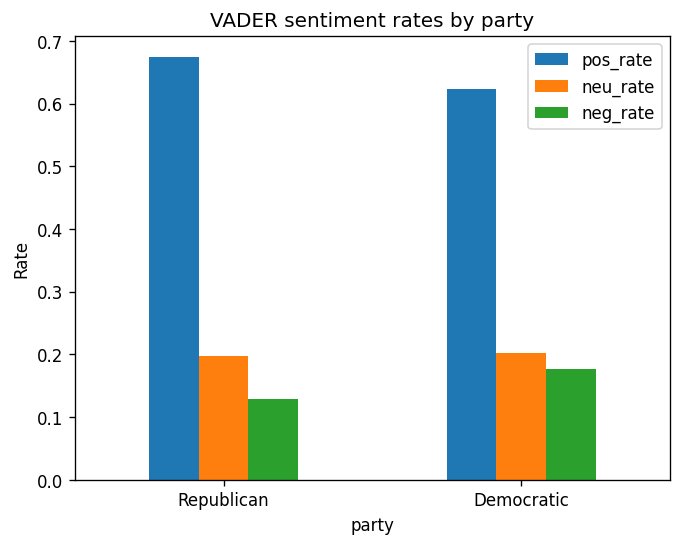

In [11]:
vader_party_summary[["pos_rate","neu_rate","neg_rate"]].plot(kind="bar")
plt.title("VADER sentiment rates by party")
plt.ylabel("Rate")
plt.xticks(rotation=0)
plt.show()


### VADER monthly sentiment trend (RQ2 baseline)

/var/folders/cg/22l6s8j10ns15kjm64ypsvhm0000gn/T/ipykernel_1638/1150899122.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["time"].dt.to_period("M").astype(str)


,month,avg_sent,n
0,2020-05,0.330788,6412
1,2020-06,0.300391,5285
2,2020-07,0.319216,4813
3,2020-08,0.318156,4711
4,2020-09,0.355412,4435
5,2020-10,0.342502,4834


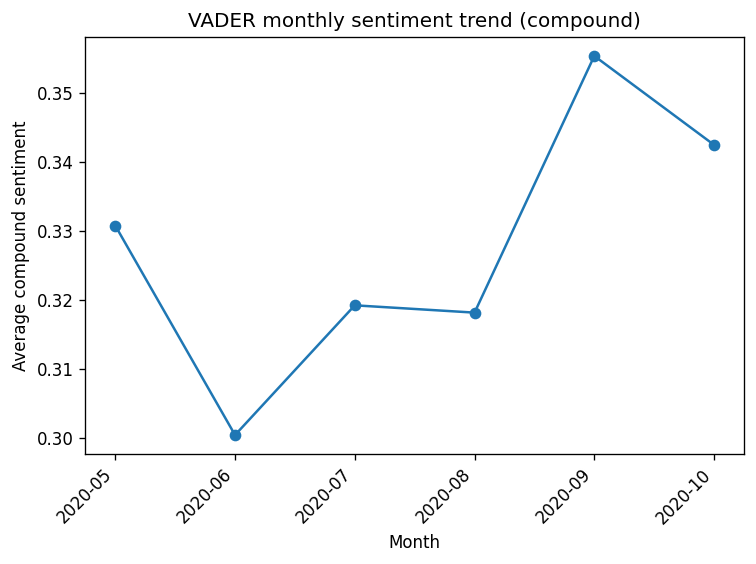

In [12]:
df["time"] = pd.to_datetime(df["time"], errors="coerce", utc=True)
df["month"] = df["time"].dt.to_period("M").astype(str)

vader_trend = (
    df.groupby("month")
      .agg(avg_sent=("vader_compound","mean"), n=("tweet_id","size"))
      .reset_index()
)

display(vader_trend)

plt.plot(vader_trend["month"], vader_trend["avg_sent"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("VADER monthly sentiment trend (compound)")
plt.xlabel("Month")
plt.ylabel("Average compound sentiment")
plt.tight_layout()
plt.show()


### VADER sentiment vs engagement (RQ3 baseline)
Engagement is heavy-tailed, so using log1p:

corr(VADER, log_likes)   = 0.0572
corr(VADER, log_retweets)= 0.0147
corr(VADER, log_replies) = 0.0263


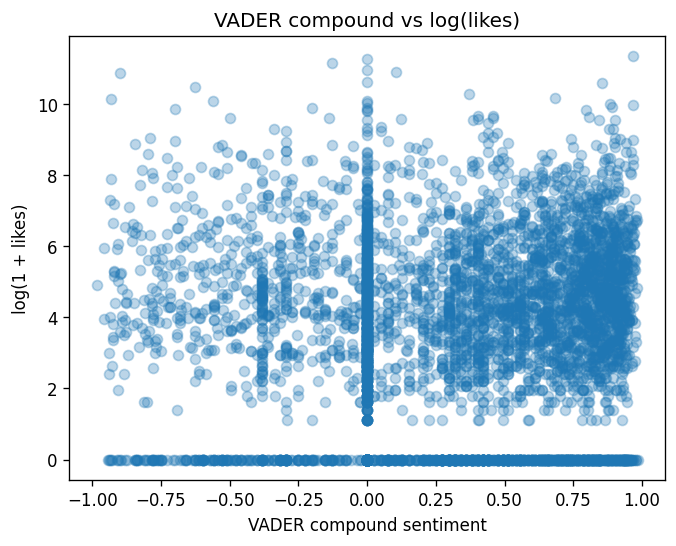

In [13]:
for col in ["likes","retweets","replies"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)
    df[f"log_{col}"] = np.log1p(df[col])

corr_likes = np.corrcoef(df["vader_compound"], df["log_likes"])[0,1]
corr_rts   = np.corrcoef(df["vader_compound"], df["log_retweets"])[0,1]
corr_rep   = np.corrcoef(df["vader_compound"], df["log_replies"])[0,1]

print("corr(VADER, log_likes)   =", round(corr_likes, 4))
print("corr(VADER, log_retweets)=", round(corr_rts, 4))
print("corr(VADER, log_replies) =", round(corr_rep, 4))

# Scatter plot (sample for readability)
sample = df.sample(n=min(5000, len(df)), random_state=42)
plt.scatter(sample["vader_compound"], sample["log_likes"], alpha=0.3)
plt.title("VADER compound vs log(likes)")
plt.xlabel("VADER compound sentiment")
plt.ylabel("log(1 + likes)")
plt.show()


In [14]:
OUT_PATH = "/Users/majid/Documents/3-third semester/text mining /senator_tweets_with_sentiment_plus_vader.csv"
df.to_csv(OUT_PATH, index=False)
print("Saved:", OUT_PATH)


Saved: /Users/majid/Documents/3-third semester/text mining /senator_tweets_with_sentiment_plus_vader.csv


### RQ1: How does sentiment distribution differ by party? (VADER)


Using VADER, both parties are mostly positive, but **Republican tweets are more positive than Democratic tweets**.

* Average sentiment (compound):

  * **Republican:** 0.3678
  * **Democratic:** 0.2982

* Positive rate:

  * **Republican:** 0.6739 (67.4%)
  * **Democratic:** 0.6225 (62.2%)

* Negative rate:

  * **Republican:** 0.1292 (12.9%)
  * **Democratic:** 0.1762 (17.6%)

So Democrats have a higher negative rate, and Republicans have a higher positive rate. This direction is the **same** as the Transformer finding, but the exact percentages are different.

---

### RQ2: Does sentiment shift over time? (VADER monthly trend)

Yes, sentiment changes by month, but the trend is **not exactly the same** as the Transformer.

* Lowest month is **June (0.3004)**.
* Sentiment is higher in **September (0.3554)** (highest point).
* October is still high (**0.3425**).

Overall, VADER shows sentiment is fairly stable around ~0.31–0.34, with a peak in September. The Transformer showed a clearer drop to July and then stronger increase. So VADER trend looks smoother and less sensitive.

---

### RQ3: Are more positive/negative tweets associated with higher engagement? (VADER)

The relationship is **weak**, similar to Transformer.

Correlations:

* sentiment vs log(likes): **0.0572** (small positive)
* sentiment vs log(retweets): **0.0147** (almost zero)
* sentiment vs log(replies): **0.0263** (very small)

So with VADER, more positive tweets get *slightly* more likes, but overall sentiment is not a strong predictor of engagement. The scatter plot also supports this because engagement values are wide for all sentiment levels.

---

## Comparison of VADER and Transformer(RoBERT) 


> “VADER produces more Positive labels than the Transformer model. This happens because VADER is a dictionary/rule-based method that reacts strongly to positive words (e.g., ‘thank’, ‘proud’, ‘great’) even in serious informational tweets. The Transformer is context-aware and therefore predicts more Neutral sentiment for official updates. However, both methods agree on the main pattern that Republican tweets are more positive on average than Democratic tweets.”



## Comparison of methods (overall)

In my project I used three sentiment approaches:

1. **Transformer (RoBERTa Twitter model)** – context-aware, gives probabilities for Negative/Neutral/Positive.
2. **VADER (dictionary / rule-based)** – counts sentiment words and rules, simple baseline.
3. **TF-IDF + Logistic Regression (supervised + tuned)** – classical ML model trained with pseudo-labels.

Even though the numbers are not identical, all methods show the **same main story**: **Republican tweets are more positive on average than Democratic tweets**, and sentiment is highest around **September**.


### Comparison table (Transformer vs VADER vs TF-IDF+LogReg)

| Method                           | Type                                                           | Labels distribution (overall)                                             | Party avg sentiment (Rep vs Dem) | Party pos rate (Rep vs Dem) | Party neg rate (Rep vs Dem) | Monthly pattern                                                 | Engagement relationship                                 |
| -------------------------------- | -------------------------------------------------------------- | ------------------------------------------------------------------------- | -------------------------------- | --------------------------- | --------------------------- | --------------------------------------------------------------- | ------------------------------------------------------- |
| **Transformer (RoBERTa)**        | Supervised Transformer (pretrained)                            | Neutral highest; Positive second; Negative lowest                         | **0.399 vs 0.234**               | **0.465 vs 0.357**          | **0.063 vs 0.131**          | Lowest around **July**, peak **September**, slight drop October | weak: likes **0.074**, RT **0.001**, replies **0.028**  |
| **VADER**                        | Dictionary / rule-based                                        | Positive very high (19,632); Neutral 6,082; Negative 4,776                | **0.368 vs 0.298**               | **0.674 vs 0.622**          | **0.129 vs 0.176**          | More stable; peak **September**                                 | weak: likes **0.057**, RT **0.015**, replies **0.026**  |
| **TF-IDF + Logistic Regression + Grid search** | Supervised ML (tuned) *(trained on Transformer pseudo-labels)* | same as training labels (Neutral 15,058; Positive 12,196; Negative 3,106) | **0.369 vs 0.191**               | **0.465 vs 0.359**          | **0.065 vs 0.138**          | Low **June/July**, peak **September**, drop October             | weak: likes **0.065**, RT **−0.007**, replies **0.018** |


### Important to note:
> “TF-IDF + Logistic Regression was trained using Transformer pseudo-labels, so its evaluation shows agreement with the Transformer model rather than true human sentiment accuracy.”




## Short conclusion 

>Overall, **Transformer and TF-IDF+LR are more consistent with each other**, because LR was trained using Transformer pseudo-labels. **VADER gives more Positive sentiment**, which is expected since it is lexicon-based and less context-aware. Despite these differences, all methods support the same main findings: Republicans tweets are more positive than Democrats, sentiment peaks in September, and engagement has only weak connection with sentiment.